### 02 - Real Space Reconstruction

This document details the three core stages of Pipeline A, which evaluates a pretrained U-Net model's ability to reconstruct undersampled magnetic resonance (MR) images. The target image is always the fully sampled ground truth.

In [1]:
import sys
from pathlib import Path

import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

project_root = Path('..').resolve()
project_root_str = str(project_root)


if project_root_str not in sys.path:
    # Use insert(0) to ensure it's the first place Python checks
    sys.path.insert(0, project_root_str)
    print(f"Added '{project_root_str}' to sys.path.")

import importlib
import src.datasets 
import src.models
import src.evaluation_utilities
importlib.reload(src.datasets)
importlib.reload(src.models)
importlib.reload(src.evaluation_utilities)
from src.datasets import RealSpaceReconDataset 
from src.models import *
from src.evaluation_utilities import calculate_metrics_model, visualize_metrics

np.random.seed(42)

Added 'C:\Users\Anna Lyamkina\OneDrive\Documents\Portfolio\fastMRI-knee-workflow' to sys.path.


#### 2.1. Testing RealSpaceReconDataset

The pipeline begins by confirming the functionality of the custom data loader, RealSpaceReconDataset. This dataset is designed to yield five critical tensors per sample:

- input_data (Normalized): The undersampled, zero-filled, and Fourier-transformed magnitude image (the network input).

- target_data (Normalized): The fully sampled ground truth magnitude image (the reconstruction target).

- mean (μ): The per-slice mean used for normalization.

- std (σ): The per-slice standard deviation used for normalization.

- max_value: The maximum magnitude value of the original (un-normalized) fully sampled slice.

In [2]:
data_root = Path("../data/raw/singlecoil_val")
train_data_file = Path("../data/labels/train_data.csv")
target_res= (320, 320)
AF = 10

train_dataset = RealSpaceReconDataset(
    manifest_path=train_data_file, 
    data_root=data_root,
    acceleration_factor=AF,
    target_resolution=target_res)
index = 10
masked_img, target_img, mean, std, max_value = train_dataset[index]
# Check shapes and types
print(f"Input (Masked Image) Shape: {masked_img.shape}, dtype: {masked_img.dtype}")
print(f"Target (Full Image) Shape: {target_img.shape}, dtype: {target_img.dtype}")
expected_shape = (1, target_res[0], target_res[1])
print("Expected shape: ", expected_shape)

Dataset initialized in mode: Unet_only
Input (Masked Image) Shape: torch.Size([1, 320, 320]), dtype: torch.float32
Target (Full Image) Shape: torch.Size([1, 320, 320]), dtype: torch.float32
Expected shape:  (1, 320, 320)


We now visualize the images returned by the instance of RealSpaceReconDataset.

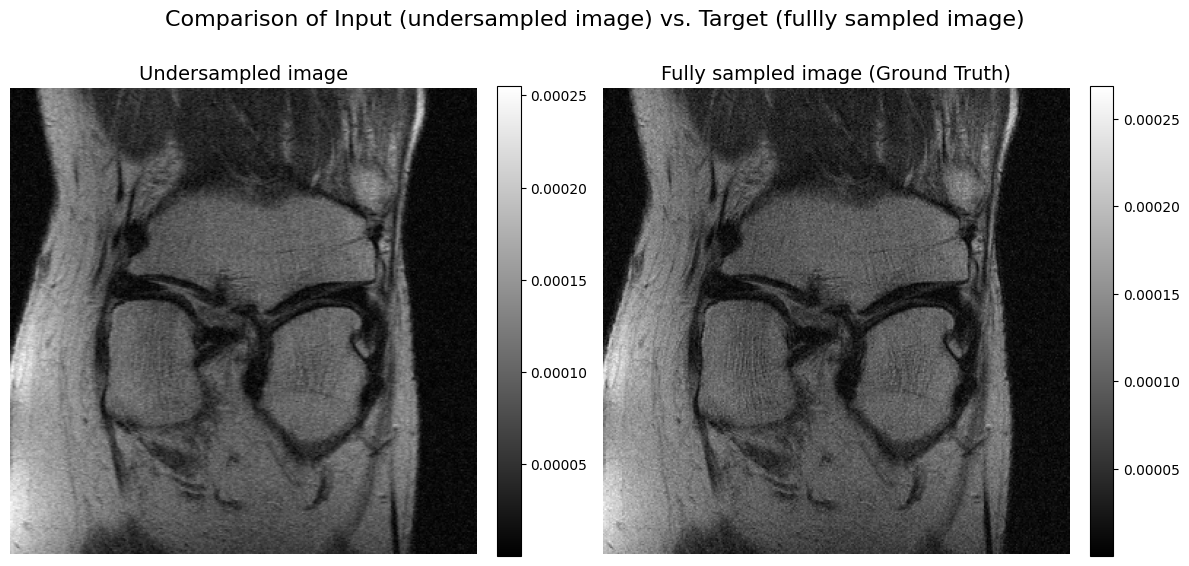

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

masked_img_denorm = denorm_image(masked_img, std = std, mean = mean)
target_img_denorm = denorm_image(target_img, std = std, mean = mean)

im1 = axes[0].imshow(masked_img_denorm[0], cmap='gray')
axes[0].set_title("Undersampled image", fontsize=14)
axes[0].axis('off')

fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(target_img_denorm[0], cmap='gray')
axes[1].set_title("Fully sampled image (Ground Truth)", fontsize=14)
axes[1].axis('off')

fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

fig.suptitle("Comparison of Input (undersampled image) vs. Target (fullly sampled image)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

Data loading works as expected.We can now proceed with modelling.

#### 2.2 Pretrained model from fastMRI project

In this project we will use a fully pretrained U-net model to reconstruct real space images. The function download_model and corresponding url and model names are acquired from from the official fastMRI github repository:

https://github.com/facebookresearch/fastMRI/blob/main/fastmri_examples/unet/run_pretrained_unet_inference.py

The download_model utility was adjusted to check if the model weights are downloaded locally. Afterwards the U-Net architecture is instantiated and loaded with these weights.

In [4]:
import requests
import os
from tqdm import tqdm 

weights_folder = Path("../models/pretrained")

UNET_FOLDER = "https://dl.fbaipublicfiles.com/fastMRI/trained_models/unet/"

MODEL_FNAMES = {
    "unet_knee_sc": "knee_sc_leaderboard_state_dict.pt",
    "unet_knee_mc": "knee_mc_leaderboard_state_dict.pt",
    "unet_brain_mc": "brain_leaderboard_state_dict.pt",
}


def download_model(url: str, fname: str):
    """
    Downloads a file from a URL to the specified local path (fname).
    """
    if os.path.exists(fname):
        print(f"✅ Model already exists at: {fname}. Skipping download.")
        return

    target_dir = os.path.dirname(fname)
    if target_dir and not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created directory: {target_dir}")

    try:
        response = requests.get(url, timeout=10, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes
    except requests.exceptions.RequestException as e:
        print(f"Error during network request: {e}")
        return

    chunk_size = 1 * 1024 * 1024  # 1 MB chunks
    total_size_in_bytes = int(response.headers.get("content-length", 0))
    
    progress_bar = tqdm(
        desc=f"Downloading {os.path.basename(fname)}",
        total=total_size_in_bytes,
        unit="iB",
        unit_scale=True,
    )

    with open(fname, "wb") as fh:
        for chunk in response.iter_content(chunk_size):
            progress_bar.update(len(chunk))
            fh.write(chunk)

    progress_bar.close()
    print(f"\nSuccessfully downloaded model to: {fname}")


file_name = MODEL_FNAMES["unet_knee_sc"]
download_url = UNET_FOLDER + file_name
weights_filepath = weights_folder/file_name

download_model(url=download_url, fname=weights_filepath)

✅ Model already exists at: ..\models\pretrained\knee_sc_leaderboard_state_dict.pt. Skipping download.


#### 2.3 Wrapper for Denormalization of U-Net Output

We introduce the UNetDenormalizationWrapper to solve a critical mismatch that arises when integrating a fixed, pre-trained denoiser (like the UNet) into a larger, end-to-end learning system. The UNet was trained on **normalized image data** (typically magnitude images scaled to a zero mean and unit variance), and its output is also in that normalized space. However, the subsequent parts of the system—the loss functions, quality metrics (like PSNR), and the final output—require data to be in the original, physical pixel range. The wrapper acts as the necessary final step, converting the UNet's normalized output back into the correct real-world scale, thus ensuring all calculations downstream are accurate and consistent.

In [5]:
pipeline_A1 = UNetDenormalizationWrapper(weights_path=weights_filepath)

Loading U-Net model from: knee_sc_leaderboard_state_dict.pt...
Checkpoint loaded
State loaded
UNet Output Denormalization Wrapper initialized.


In [6]:
pipeline_A2 = DataConsistencyWrapper(weights_path=weights_filepath, num_iterations = 2)

Loading U-Net model from: knee_sc_leaderboard_state_dict.pt...
Checkpoint loaded
State loaded
Data Consistency Wrapper initialized with fixed lambda: 1


#### 3 Pipeline evaluation

We will now evaluate the performance of pipeline A by calculating following metrics:

1. Root Mean Squared Error (RMSE)

RMSE is calculated directly on the denormalized prediction and target.

$$ RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^{N}​(Prediction_{denorm,i}​−Target_{denorm,i​})^2} $$

2. Peak Signal-to-Noise Ratio (PSNR)

PSNR is highly sensitive to the defined data range, which is why the max_value (the maximum magnitude of the original ground truth image) is crucial.

$$ PSNR=10⋅log_{10}​(\frac{​(MAX\_VALUE)^2}{MSE_{denorm}}​) $$
​
3. Structural Similarity Index Measure (SSIM)

The Structural Similarity Index Measure (SSIM) is a perceptual metric designed to quantify the perceived quality of a degraded image relative to its original, uncompressed reference. Unlike simple error calculations like PSNR, SSIM models the human visual system by focusing on the three primary components of an image's structure: luminance, contrast, and correlation (structure). The final score is a decimal value between 0 (no similarity) and 1 (perfect similarity), reflecting how visually similar two images are to a human observer.

Similar to PSNR, the SSIM metric must also be calculated with the correct maximum possible pixel value, which is provided by the per-slice max_value. This ensures the SSIM score accurately reflects perceptual quality within the correct dynamic range of the MR image.


The metrics are calculated on the validation set, for a demo we will use a subset of 10 samples. 

**Important Note: Denormalization**

The U-Net model operates entirely on normalized data (where values are centered around zero and scaled by standard deviation). However, standard image quality metrics (RMSE, PSNR, SSIM) must be calculated on the original denormalized magnitude image values to provide meaningful results.

Sonce we introduced a wrapper around U-Net thta already returns a denormalized image, before any metric is calculated, both only the ground truth target must be denormalized using the inverse of the μ/σ operation:

$$ Y_{denorm}​=(Y_{norm}​⋅std)+mean $$

In [7]:
val_data_file = Path("../data/labels/val_data.csv")

validation_dataset_A1 = RealSpaceReconDataset(
    manifest_path=val_data_file, 
    data_root=data_root,
    acceleration_factor=AF,
    target_resolution=target_res,
    pipeline_mode="Unet_only")
validation_loader_A1 = DataLoader(validation_dataset_A1, batch_size=1, shuffle=False)

validation_dataset_A2 = RealSpaceReconDataset(
    manifest_path=val_data_file, 
    data_root=data_root,
    acceleration_factor=AF,
    target_resolution=target_res,
    pipeline_mode="Unet_DataConsistency")
validation_loader_A2 = DataLoader(validation_dataset_A2, batch_size=1, shuffle=False)


Dataset initialized in mode: Unet_only
Dataset initialized in mode: Unet_DataConsistency


Samples processed: 10


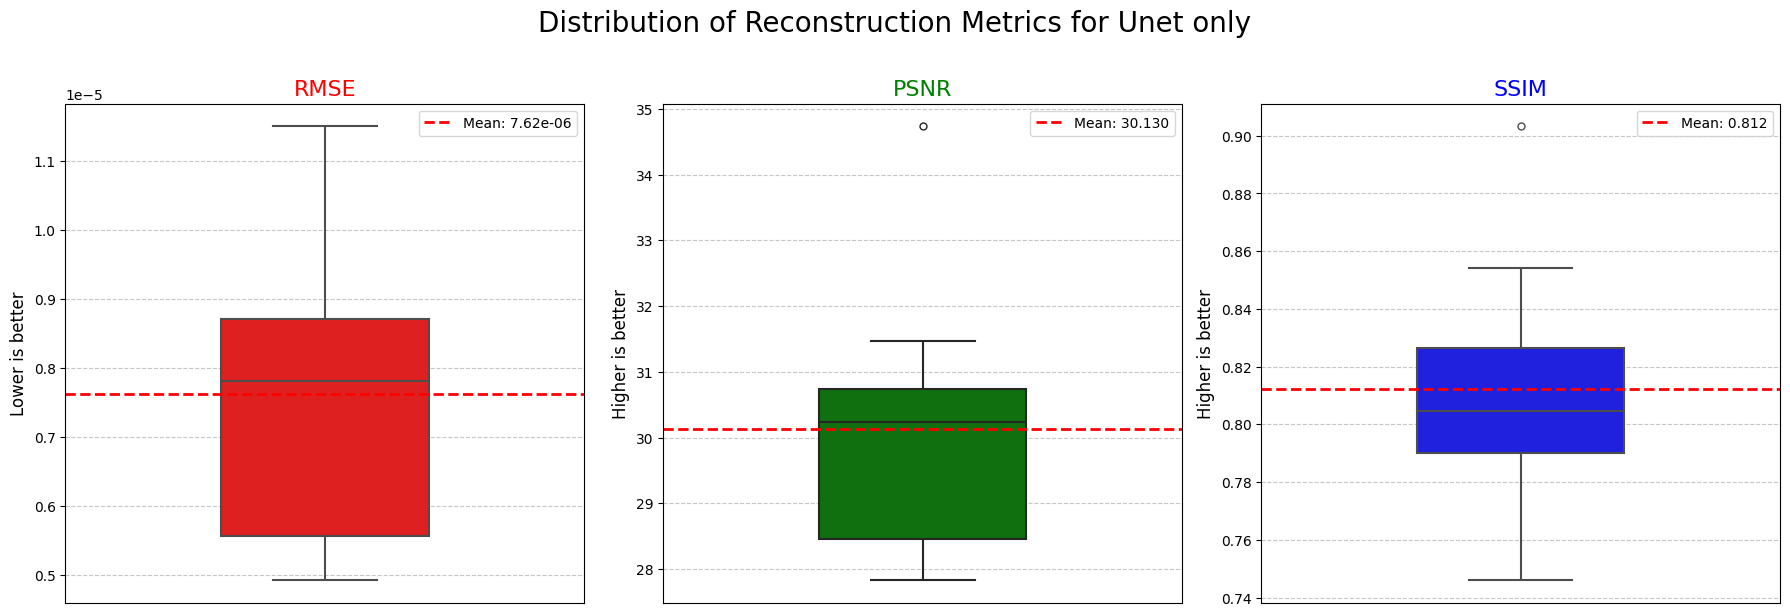

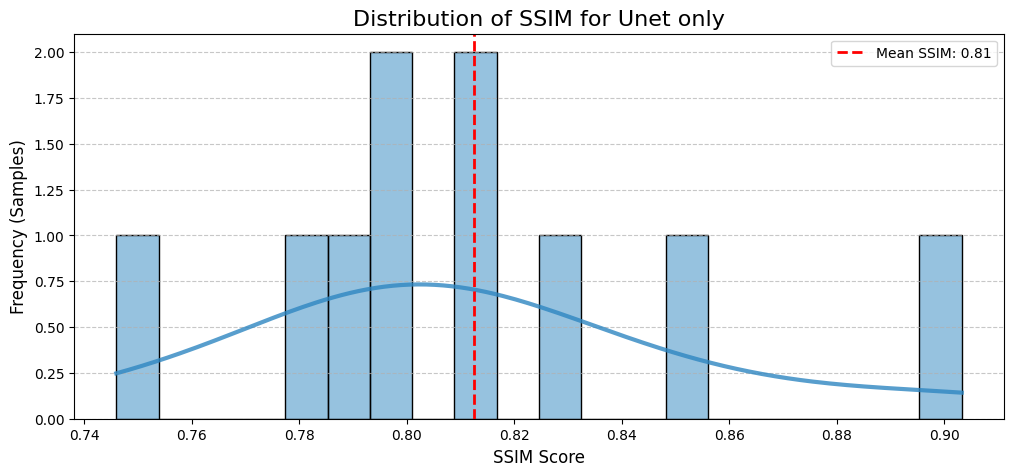

In [8]:
rmse_scores_A1, psnr_scores_A1, ssim_scores_A1 = calculate_metrics_model(validation_loader_A1, model=pipeline_A1, nsamples = 10, model_type = "Unet_only")
visualize_metrics(rmse_scores_A1, psnr_scores_A1, ssim_scores_A1, model_name="Unet only")

Samples processed: 10


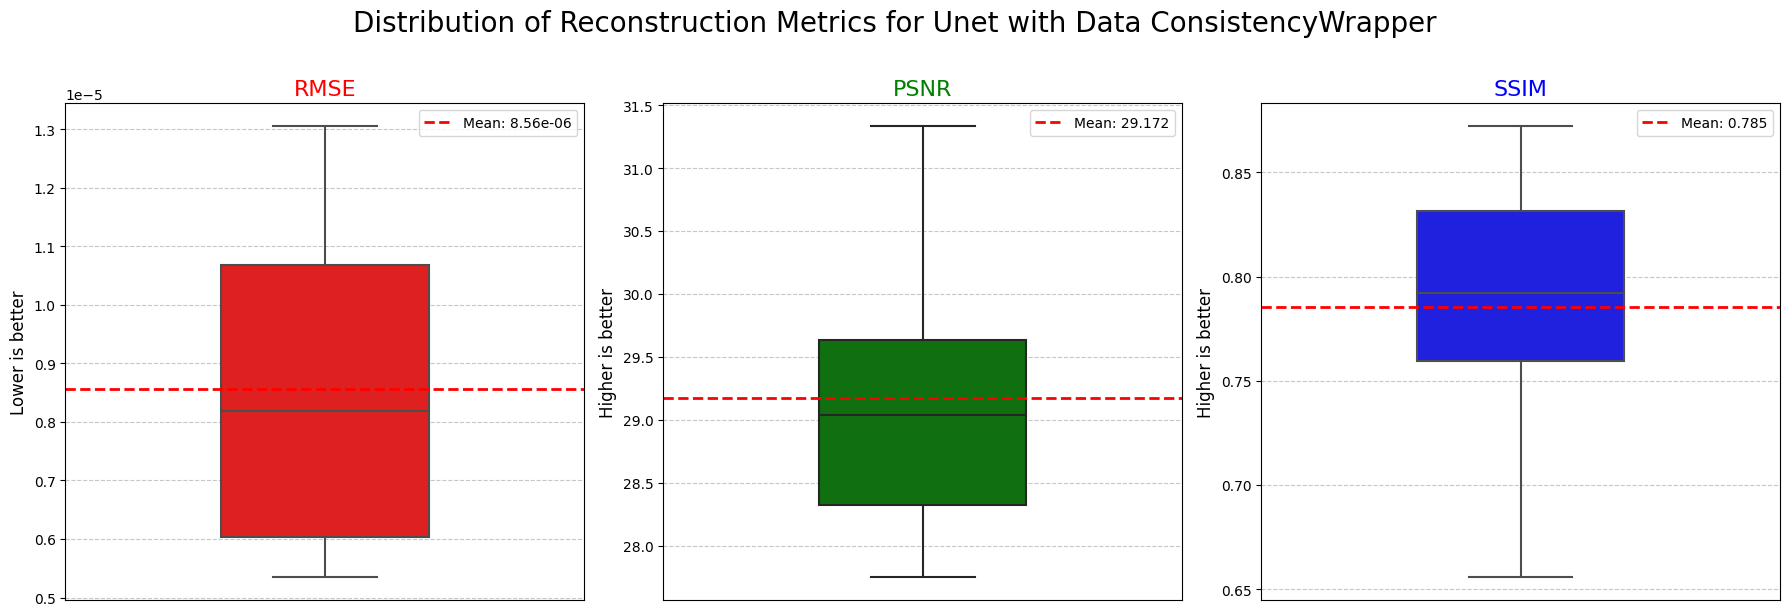

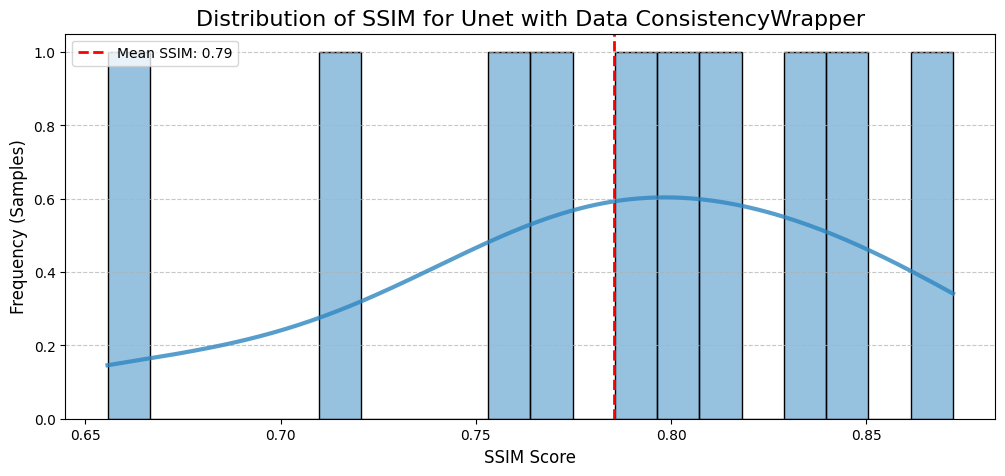

In [9]:
rmse_scores_A2, psnr_scores_A2, ssim_scores_A2 = calculate_metrics_model(validation_loader_A2, model=pipeline_A2, nsamples = 10, model_type = "Unet_DataConsistency")
visualize_metrics(rmse_scores_A2, psnr_scores_A2, ssim_scores_A2, model_name="Unet with Data ConsistencyWrapper")

#### 2.4 Final Visualization

The last step provides a qualitative assessment of the reconstruction performance. The following images are displayed:

- Undersampled Input: The zero-filled image used as input.

- Reconstructed Image: The U-Net's denormalized output.

-  Data Consistent Reconstructed Image: the output of DataConsistencyWrapper that reinforces the measured k data to be kept in the final image

- Ground Truth: The fully sampled denormalized target.

This allows for visual confirmation of how closely the reconstructed image matches the ground truth and helps identify common reconstruction artifacts.

In [10]:
for kspace_masked, mask, masked_img, target_img, mean, std, max_value in validation_loader_A2:
    break
pred_unet = pipeline_A1(masked_img, mean, std)
pred_DC_unet = pipeline_A2(kspace_masked, mask, masked_img, mean, std)
masked_img_denorm = denorm_image(masked_img, std = std, mean = mean)
target_denorm = denorm_image(target_img, std = std, mean = mean)

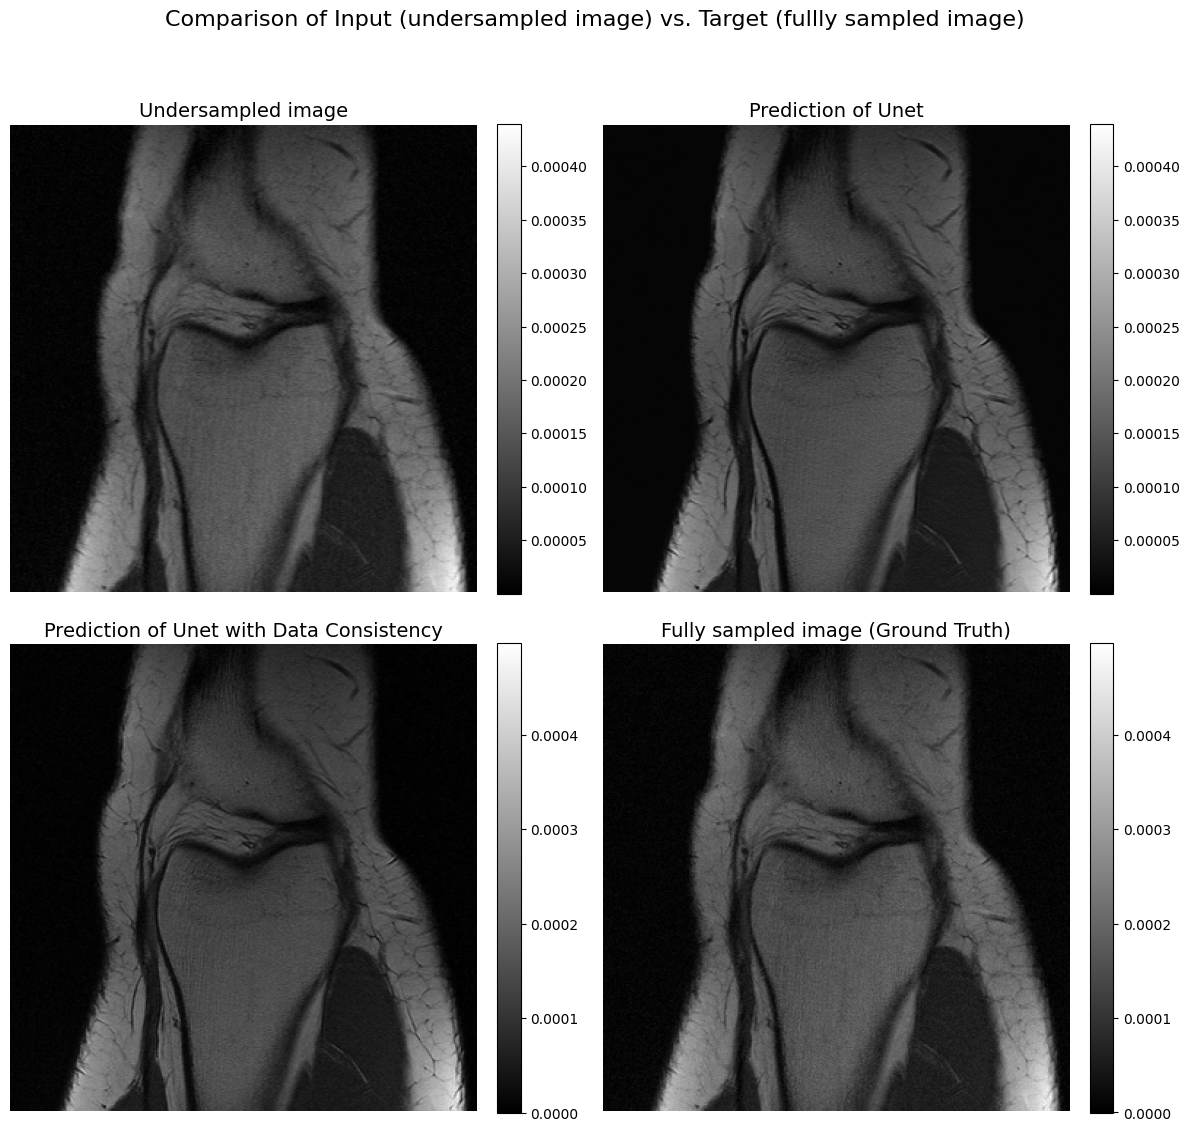

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

im1 = axes[0, 0].imshow(masked_img_denorm[0][0], cmap='gray')
axes[0, 0].set_title("Undersampled image", fontsize=14)
axes[0, 0].axis('off')

fig.colorbar(im1, ax=axes[0, 0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[0, 1].imshow(pred_unet[0][0], cmap='gray')
axes[0, 1].set_title("Prediction of Unet", fontsize=14)
axes[0, 1].axis('off')

fig.colorbar(im1, ax=axes[0, 1], orientation='vertical', fraction=0.046, pad=0.04)

im3 = axes[1, 0].imshow(pred_DC_unet[0][0], cmap='gray')
axes[1, 0].set_title("Prediction of Unet with Data Consistency", fontsize=14)
axes[1, 0].axis('off')

fig.colorbar(im2, ax=axes[1, 0], orientation='vertical', fraction=0.046, pad=0.04)

im4 = axes[1, 1].imshow(target_denorm[0][0], cmap='gray')
axes[1, 1].set_title("Fully sampled image (Ground Truth)", fontsize=14)
axes[1, 1].axis('off')

fig.colorbar(im2, ax=axes[1, 1], orientation='vertical', fraction=0.046, pad=0.04)

fig.suptitle("Comparison of Input (undersampled image) vs. Target (fullly sampled image)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()